In [1]:
# Modules to load mesh and solution data
using GridapGmsh, Gridap
using LinearAlgebra
using JLD
using GridapMakie, CairoMakie, Plots

In [ ]:
fstr = "TopOpt_bw01N3_fsr30M21Cf036sqrtM"

phys_params = load(fstr*".jld", "phys_params")
opt_params = load(fstr*".jld", "opt_params")
filter_params = load(fstr*".jld", "filter_params")

(N = 3, fcenter = 1.0, fbandwidth = 0.01, filtertype = "bandpass", profile = "ellip", pass = 0.25, stop = 25, poles = ComplexF64[0.9944584564716545 - 0.0015090326279055379im, 0.999977668101735 - 0.004434331721492533im, 1.0055449686473366 - 0.0015258557626417382im], σs = Complex{Int64}[0 - 1im, 0 + 1im, 0 - 1im], t∞ = 0, r∞ = -0.0 - 1.0im)

In [19]:
# Load mesh
mshfile = "TopOpt_H025_D300_md7.msh"
model = GmshDiscreteModel(mshfile)

degree = 2
Ω = Triangulation(model)
dΩ = Measure(Ω, degree)
Ω_d = Triangulation(model, tags="Design")
dΩ_d = Measure(Ω_d, degree)

p_reffe = ReferenceFE(lagrangian, Float64, 0)
P = TestFESpace(Ω_d, p_reffe, vector_type = Vector{Float64})
pf_reffe = ReferenceFE(lagrangian, Float64, 1)
Pf = TestFESpace(Ω_d, pf_reffe, vector_type = Vector{Float64})

reffe = ReferenceFE(lagrangian, Float64, 1)
U = TestFESpace(model, reffe,vector_type = Vector{ComplexF64})

fem_params = (; P, Pf, U, dΩ_d)

a_f(u, v) = opt_params.r^2 * (∇(v) ⋅ ∇(u)) + (v * u)
Af = assemble_matrix(fem_params.Pf, fem_params.Pf) do u, v
    ∫(a_f(u, v))fem_params.dΩ_d
end
Af_chol = cholesky(Symmetric(Af)) # Af is real symmetric (Af = Af')

function pFilter(p0; fem_params)
    ph = FEFunction(fem_params.P, p0)
    p_vec = assemble_vector(v -> ∫(v * ph)fem_params.dΩ_d, fem_params.Pf)
    pf_vec = Af_chol \ p_vec
    return FEFunction(fem_params.Pf, pf_vec)
end

function pThreshold(pfh; β, η)
    return ((tanh(β * η) + tanh(β * (pfh - η))) / (tanh(β * η) + tanh(β * (1.0 - η))))
end

# Load solution data
pf = load(fstr*".jld", "final_p")
pffh = pFilter(pf; fem_params)
pfth = (pf -> pThreshold(pf; β=opt_params.β, η=opt_params.η)) ∘ pffh

# Total material
pftot = sum(∫(pfth)fem_params.dΩ_d)
ptotScale = filter_params.N*phys_params.H*(0.5/phys_params.n_hi)
pftot/ptotScale

Info    : Reading 'TopOpt_H025_D300_md7.msh'...
Info    : 21 entities
Info    : 2647 nodes
Info    : 5324 elements
Info    : Done reading 'TopOpt_H025_D300_md7.msh'


1.77819932441971

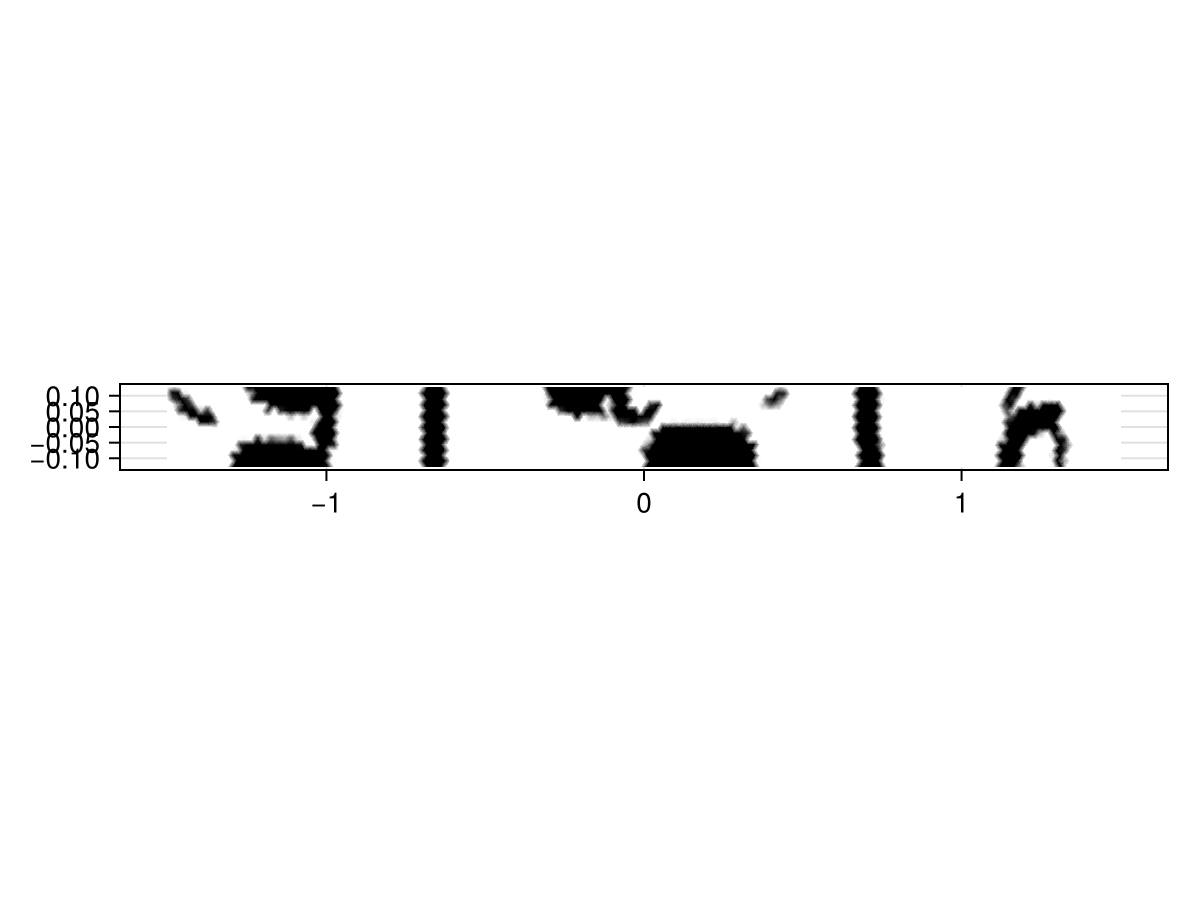

In [20]:
# Plot designed structure
fig, ax, plt = CairoMakie.plot(Ω_d, pfth, colormap=:binary);
ax.aspect = DataAspect();
#Makie.save(fstr*"_structure.png", fig)
fig

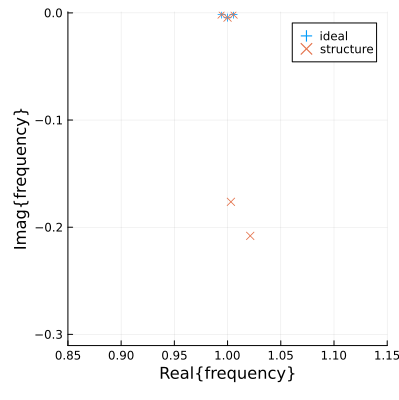

In [21]:
# Load and plot target and designed poles
final_poles = load(fstr*"_response.jld", "final_poles")
final_vecs = load(fstr*"_response.jld", "final_vecs")
final_σs = load(fstr*"_response.jld", "final_σs")
#ip1 = sortperm(real(final_poles))
#show_poles = final_poles[ip1]
#show_vecs = final_vecs[ip1]
#show_σs = final_σs[ip1]
#[show_poles show_σs]

pltP = Plots.scatter(real(filter_params.poles), imag(filter_params.poles), markershape=:+, label="ideal", size=(400,400))
Plots.scatter!(pltP, real(final_poles), imag(final_poles), markershape=:xcross, label="structure")
x1 = 1-opt_params.fsr/2-1e-8; x2 = 1+opt_params.fsr/2+1e-8
Plots.xlims!(x1, x2); Plots.xlabel!("Real{frequency}")
Plots.ylims!(minimum(imag(filter_params.poles))*70, 1e-3); Plots.ylabel!("Imag{frequency}")

#savefig(pltP, fstr*"_poles.png")
pltP


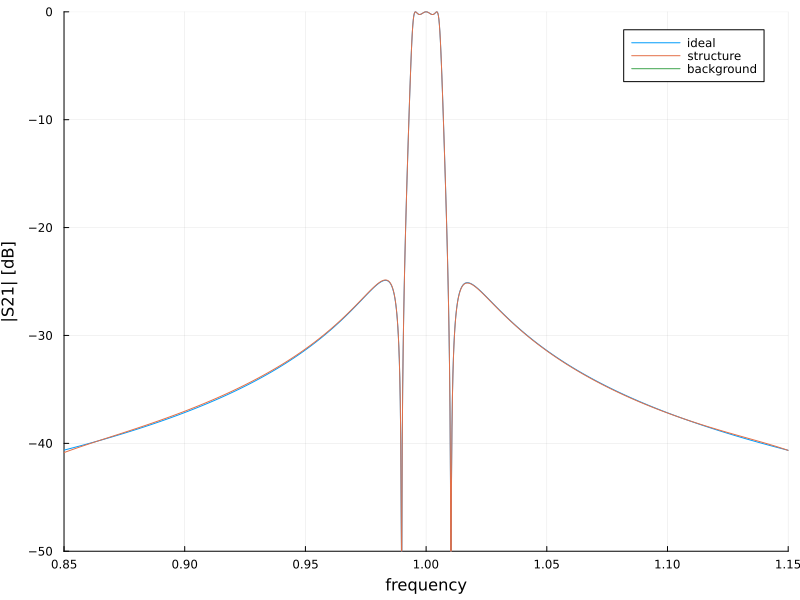

In [22]:
# Load and plot solution response
plot_fs = load(fstr*"_response.jld", "plot_fs")
i1 = findfirst(plot_fs .>= x1); ip = i1:length(plot_fs)-i1+1

S21 = load(fstr*"_response.jld", "S21")
T = abs2.(S21)
S11 = load(fstr*"_response.jld", "S11")
R = abs2.(S11)

C21 = load(fstr*"_response.jld", "C21")
TC = abs2.(C21)
C11 = load(fstr*"_response.jld", "C11")
RC = abs2.(C11)

P21 = load(fstr*"_response.jld", "P21")
TP = abs2.(P21)
P11 = load(fstr*"_response.jld", "P11")
RP = abs2.(P11)

#Plots.plot!(pltS, plot_fs, 10*log10.(R .+ T));
if filter_params.filtertype == "bandpass"
    pltS = Plots.plot(plot_fs[ip], 10*log10.(TP[ip]), label="ideal", size=(800,600))
    Plots.plot!(pltS, plot_fs[ip], 10*log10.(T[ip]), label="structure")
    Plots.plot!(pltS, plot_fs[ip], 10*log10.(TC[ip]), label="background")
    Plots.ylabel!("|S21| [dB]")
elseif filter_params.filtertype == "bandstop"
    pltS = Plots.plot(plot_fs[ip], 10*log10.(RP[ip]), label="ideal", size=(800,600))
    Plots.plot!(pltS, plot_fs[ip], 10*log10.(R[ip]), label="structure")
    Plots.plot!(pltS, plot_fs[ip], 10*log10.(RC[ip]), label="background")
    Plots.ylabel!("|S11| [dB]")
end
Plots.xlims!(x1, x2); Plots.xlabel!("frequency")
Plots.ylims!(-filter_params.stop*2, 1e-8)

#savefig(pltS, fstr*"_response.png")
pltS

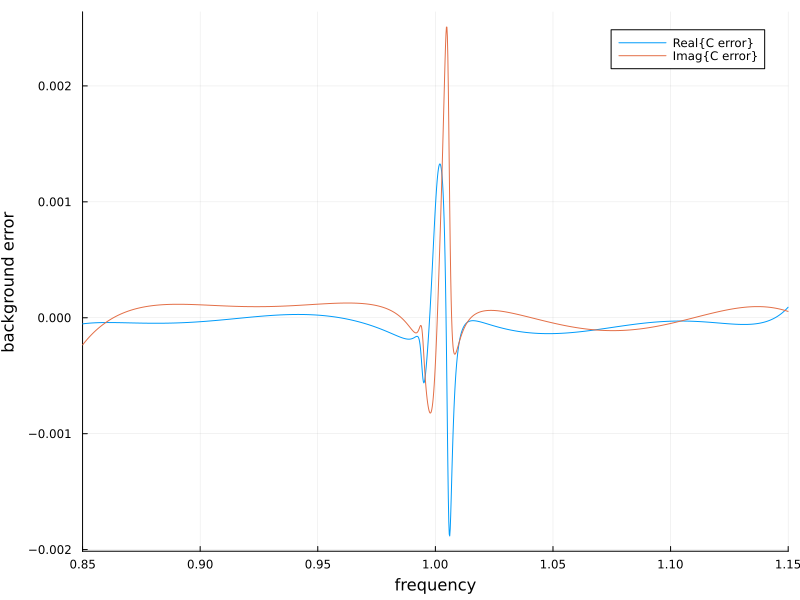

In [23]:
# Plot error for background objective
cc = (C21/conj(filter_params.r∞) .- filter_params.t∞ ./conj(C11))

pltC = Plots.plot(plot_fs[ip], real(cc[ip]), label="Real{C error}", size=(800,600))
Plots.plot!(pltC, plot_fs[ip], imag(cc[ip]), label="Imag{C error}")
Plots.xlims!(x1, x2); Plots.xlabel!("frequency")
Plots.ylabel!("background error")